In [1]:
import torch

In [ ]:
pip install datasets

In [3]:
from datasets import load_dataset

data = load_dataset("xsum")

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

Dataset xsum downloaded and prepared to /root/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
data['train']=data['train'].select(range(25000)) # 51000
data['validation']=data['validation'].select(range(1416)) # 2833
data['test']=data['test'].select(range(1416))

In [ ]:
def show_samples(data, num_samples=3, seed=42):
    sample = data["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(f"\n'>> Title: {example['summary']}'")
        print(f"'>> Review: {example['document']}'")


show_samples(data)

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets
import seaborn as sns

In [6]:
data.set_format( "pandas" ) 
df = data[ "train" ][:]

In [7]:
df['document len'] = df['document'].apply(lambda x: len(x.split()))
df['summary len'] = df['summary'].apply(lambda x: len(x.split()))

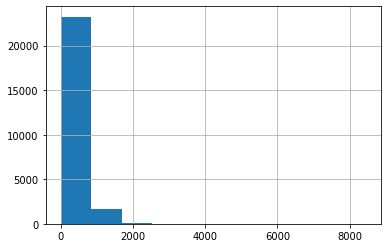

In [8]:
h = df['document len'].hist()
fig = h.get_figure()

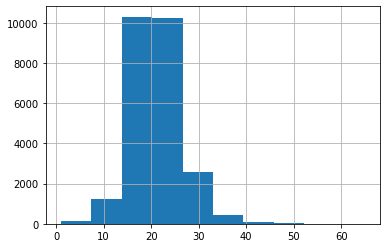

In [9]:
h = df['summary len'].hist()
fig = h.get_figure()

In [10]:
len(df[(df['summary len']<24) & (df['summary len']>17)])

11417

In [11]:
data.reset_format()

In [12]:
data = data.filter(lambda x: (len(x["summary"].split()) >= 24) or (len(x["summary"].split()) <= 17))

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [13]:
len(data['train'])

13583

In [14]:
pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.8 MB/s 


In [15]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 4.7 MB/s 
     |████████████████████████████████| 7.6 MB 45.8 MB/s 


In [16]:
from transformers import AutoTokenizer

model_checkpoint = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [17]:
max_input_length = 512
max_target_length = 30


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["document"],
        max_length=max_input_length,
        truncation=True,
        pad_to_max_length=True
    )
    targets = examples['summary']
    labels = tokenizer(text_target=targets,max_length=max_target_length, truncation=True, pad_to_max_length=True)
    model_inputs["labels"] = labels["input_ids"]
    model_inputs["labels_mask"] = labels["attention_mask"]
    return model_inputs

In [18]:
tokenized_data = data.map(preprocess_function, batched=True)

  0%|          | 0/14 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [19]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base')

Downloading:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [20]:
from transformers import Seq2SeqTrainingArguments

batch_size = 10
num_train_epochs = 5
# Show the training loss with every epoch
logging_steps = len(tokenized_data["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-facebook",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    push_to_hub=True,
)

In [22]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [23]:
import nltk

nltk.download("punkt")
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
!pip install torchmetrics

чтобы посчитать Rouge-score воспользуемся https://torchmetrics.readthedocs.io/en/stable/text/rouge_score.html

In [25]:
import numpy as np
from torchmetrics.text.rouge import ROUGEScore

rouge = ROUGEScore(use_stemmer=True)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]

    result = rouge(
        ' '.join(decoded_preds), ' '.join(decoded_labels)
    )
    print(result)

    return {
        'rouge1': round(float(result['rouge1_fmeasure']), 4),
        'rouge2': round(float(result['rouge2_fmeasure']), 4),
        'rougeL': round(float(result['rougeL_fmeasure']), 4),
        'rougeLsum': round(float(result['rougeLsum_fmeasure']), 4)
    }

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
model.cuda()

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: labels_mask, id, document, summary. If labels_mask, id, document, summary are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 13583
  Num Epochs = 5
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 6795
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,2.505000,2.104829,0.678800,0.302200,0.284300,0.649700
2,2.021600,2.101017,0.702200,0.318200,0.297400,0.672000
3,1.708800,2.122827,0.704800,0.321400,0.296800,0.672200
4,1.477800,2.165529,0.711700,0.325000,0.298400,0.678600
5,1.316100,2.187650,0.714600,0.330500,0.298800,0.682200


Saving model checkpoint to bart-base-facebook/checkpoint-500
Configuration saved in bart-base-facebook/checkpoint-500/config.json
Model weights saved in bart-base-facebook/checkpoint-500/pytorch_model.bin
tokenizer config file saved in bart-base-facebook/checkpoint-500/tokenizer_config.json
Special tokens file saved in bart-base-facebook/checkpoint-500/special_tokens_map.json
tokenizer config file saved in bart-base-facebook/tokenizer_config.json
Special tokens file saved in bart-base-facebook/special_tokens_map.json
Saving model checkpoint to bart-base-facebook/checkpoint-1000
Configuration saved in bart-base-facebook/checkpoint-1000/config.json
Model weights saved in bart-base-facebook/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in bart-base-facebook/checkpoint-1000/tokenizer_config.json
Special tokens file saved in bart-base-facebook/checkpoint-1000/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BartForCo

{'rouge1_fmeasure': tensor(0.6788), 'rouge1_precision': tensor(0.8457), 'rouge1_recall': tensor(0.5670), 'rouge2_fmeasure': tensor(0.3022), 'rouge2_precision': tensor(0.3765), 'rouge2_recall': tensor(0.2524), 'rougeL_fmeasure': tensor(0.2843), 'rougeL_precision': tensor(0.3542), 'rougeL_recall': tensor(0.2375), 'rougeLsum_fmeasure': tensor(0.6497), 'rougeLsum_precision': tensor(0.8094), 'rougeLsum_recall': tensor(0.5426)}


Saving model checkpoint to bart-base-facebook/checkpoint-1500
Configuration saved in bart-base-facebook/checkpoint-1500/config.json
Model weights saved in bart-base-facebook/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in bart-base-facebook/checkpoint-1500/tokenizer_config.json
Special tokens file saved in bart-base-facebook/checkpoint-1500/special_tokens_map.json
Saving model checkpoint to bart-base-facebook/checkpoint-2000
Configuration saved in bart-base-facebook/checkpoint-2000/config.json
Model weights saved in bart-base-facebook/checkpoint-2000/pytorch_model.bin
tokenizer config file saved in bart-base-facebook/checkpoint-2000/tokenizer_config.json
Special tokens file saved in bart-base-facebook/checkpoint-2000/special_tokens_map.json
Deleting older checkpoint [bart-base-facebook/checkpoint-500] due to args.save_total_limit
Saving model checkpoint to bart-base-facebook/checkpoint-2500
Configuration saved in bart-base-facebook/checkpoint-2500/config.json
Model wei

{'rouge1_fmeasure': tensor(0.7022), 'rouge1_precision': tensor(0.8668), 'rouge1_recall': tensor(0.5901), 'rouge2_fmeasure': tensor(0.3182), 'rouge2_precision': tensor(0.3928), 'rouge2_recall': tensor(0.2674), 'rougeL_fmeasure': tensor(0.2974), 'rougeL_precision': tensor(0.3672), 'rougeL_recall': tensor(0.2499), 'rougeLsum_fmeasure': tensor(0.6720), 'rougeLsum_precision': tensor(0.8296), 'rougeLsum_recall': tensor(0.5648)}


Saving model checkpoint to bart-base-facebook/checkpoint-3000
Configuration saved in bart-base-facebook/checkpoint-3000/config.json
Model weights saved in bart-base-facebook/checkpoint-3000/pytorch_model.bin
tokenizer config file saved in bart-base-facebook/checkpoint-3000/tokenizer_config.json
Special tokens file saved in bart-base-facebook/checkpoint-3000/special_tokens_map.json
Deleting older checkpoint [bart-base-facebook/checkpoint-1500] due to args.save_total_limit
Saving model checkpoint to bart-base-facebook/checkpoint-3500
Configuration saved in bart-base-facebook/checkpoint-3500/config.json
Model weights saved in bart-base-facebook/checkpoint-3500/pytorch_model.bin
tokenizer config file saved in bart-base-facebook/checkpoint-3500/tokenizer_config.json
Special tokens file saved in bart-base-facebook/checkpoint-3500/special_tokens_map.json
Deleting older checkpoint [bart-base-facebook/checkpoint-2000] due to args.save_total_limit
Saving model checkpoint to bart-base-facebook/ch

{'rouge1_fmeasure': tensor(0.7048), 'rouge1_precision': tensor(0.8665), 'rouge1_recall': tensor(0.5939), 'rouge2_fmeasure': tensor(0.3214), 'rouge2_precision': tensor(0.3952), 'rouge2_recall': tensor(0.2709), 'rougeL_fmeasure': tensor(0.2968), 'rougeL_precision': tensor(0.3649), 'rougeL_recall': tensor(0.2501), 'rougeLsum_fmeasure': tensor(0.6722), 'rougeLsum_precision': tensor(0.8265), 'rougeLsum_recall': tensor(0.5665)}


Saving model checkpoint to bart-base-facebook/checkpoint-4500
Configuration saved in bart-base-facebook/checkpoint-4500/config.json
Model weights saved in bart-base-facebook/checkpoint-4500/pytorch_model.bin
tokenizer config file saved in bart-base-facebook/checkpoint-4500/tokenizer_config.json
Special tokens file saved in bart-base-facebook/checkpoint-4500/special_tokens_map.json
Deleting older checkpoint [bart-base-facebook/checkpoint-3000] due to args.save_total_limit
Saving model checkpoint to bart-base-facebook/checkpoint-5000
Configuration saved in bart-base-facebook/checkpoint-5000/config.json
Model weights saved in bart-base-facebook/checkpoint-5000/pytorch_model.bin
tokenizer config file saved in bart-base-facebook/checkpoint-5000/tokenizer_config.json
Special tokens file saved in bart-base-facebook/checkpoint-5000/special_tokens_map.json
Deleting older checkpoint [bart-base-facebook/checkpoint-3500] due to args.save_total_limit
The following columns in the evaluation set don'

{'rouge1_fmeasure': tensor(0.7117), 'rouge1_precision': tensor(0.8679), 'rouge1_recall': tensor(0.6031), 'rouge2_fmeasure': tensor(0.3250), 'rouge2_precision': tensor(0.3964), 'rouge2_recall': tensor(0.2754), 'rougeL_fmeasure': tensor(0.2984), 'rougeL_precision': tensor(0.3640), 'rougeL_recall': tensor(0.2529), 'rougeLsum_fmeasure': tensor(0.6786), 'rougeLsum_precision': tensor(0.8276), 'rougeLsum_recall': tensor(0.5750)}


Saving model checkpoint to bart-base-facebook/checkpoint-5500
Configuration saved in bart-base-facebook/checkpoint-5500/config.json
Model weights saved in bart-base-facebook/checkpoint-5500/pytorch_model.bin
tokenizer config file saved in bart-base-facebook/checkpoint-5500/tokenizer_config.json
Special tokens file saved in bart-base-facebook/checkpoint-5500/special_tokens_map.json
Deleting older checkpoint [bart-base-facebook/checkpoint-4000] due to args.save_total_limit
Saving model checkpoint to bart-base-facebook/checkpoint-6000
Configuration saved in bart-base-facebook/checkpoint-6000/config.json
Model weights saved in bart-base-facebook/checkpoint-6000/pytorch_model.bin
tokenizer config file saved in bart-base-facebook/checkpoint-6000/tokenizer_config.json
Special tokens file saved in bart-base-facebook/checkpoint-6000/special_tokens_map.json
Deleting older checkpoint [bart-base-facebook/checkpoint-4500] due to args.save_total_limit
Saving model checkpoint to bart-base-facebook/ch

{'rouge1_fmeasure': tensor(0.7146), 'rouge1_precision': tensor(0.8748), 'rouge1_recall': tensor(0.6040), 'rouge2_fmeasure': tensor(0.3305), 'rouge2_precision': tensor(0.4045), 'rouge2_recall': tensor(0.2793), 'rougeL_fmeasure': tensor(0.2988), 'rougeL_precision': tensor(0.3657), 'rougeL_recall': tensor(0.2525), 'rougeLsum_fmeasure': tensor(0.6822), 'rougeLsum_precision': tensor(0.8351), 'rougeLsum_recall': tensor(0.5767)}




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=6795, training_loss=1.8055454216957794, metrics={'train_runtime': 6925.0335, 'train_samples_per_second': 9.807, 'train_steps_per_second': 0.981, 'total_flos': 2.06892214244352e+16, 'train_loss': 1.8055454216957794, 'epoch': 5.0})

In [ ]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: labels_mask, id, document, summary. If labels_mask, id, document, summary are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 798
  Batch size = 10


{'rouge1_fmeasure': tensor(0.7146), 'rouge1_precision': tensor(0.8748), 'rouge1_recall': tensor(0.6040), 'rouge2_fmeasure': tensor(0.3305), 'rouge2_precision': tensor(0.4045), 'rouge2_recall': tensor(0.2793), 'rougeL_fmeasure': tensor(0.2988), 'rougeL_precision': tensor(0.3657), 'rougeL_recall': tensor(0.2525), 'rougeLsum_fmeasure': tensor(0.6822), 'rougeLsum_precision': tensor(0.8351), 'rougeLsum_recall': tensor(0.5767)}


{'eval_loss': 2.187650203704834,
 'eval_rouge1': 0.7146,
 'eval_rouge2': 0.3305,
 'eval_rougeL': 0.2988,
 'eval_rougeLsum': 0.6822,
 'eval_runtime': 379.6967,
 'eval_samples_per_second': 2.102,
 'eval_steps_per_second': 0.211,
 'epoch': 5.0}

сохранение обученной модели в huggingface репозиторий

In [ ]:
trainer.push_to_hub(commit_message="Training complete", tags="summarization")

Saving model checkpoint to bart-base-facebook
Configuration saved in bart-base-facebook/config.json
Model weights saved in bart-base-facebook/pytorch_model.bin
tokenizer config file saved in bart-base-facebook/tokenizer_config.json
Special tokens file saved in bart-base-facebook/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/532M [00:00<?, ?B/s]

Upload file runs/Oct10_17-38-36_365704bcb3c8/events.out.tfevents.1665431046.365704bcb3c8.68.2: 100%|##########…

Upload file runs/Oct10_17-38-36_365704bcb3c8/events.out.tfevents.1665423740.365704bcb3c8.68.0:  41%|####      …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/sunsvrv/bart-base-facebook
   9536e59..0f48a22  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/sunsvrv/bart-base-facebook
   9536e59..0f48a22  main -> main

To https://huggingface.co/sunsvrv/bart-base-facebook
   0f48a22..f1d86df  main -> main

   0f48a22..f1d86df  main -> main



'https://huggingface.co/sunsvrv/bart-base-facebook/commit/0f48a2264586e129d40e9e58c98ebd22c2ef86ce'

In [ ]:
tokenized_data['train']

Dataset({
    features: ['document', 'summary', 'id', 'input_ids', 'attention_mask', 'labels', 'labels_mask'],
    num_rows: 13583
})

In [26]:
input_ids = torch.tensor(tokenized_data['train']['input_ids'], dtype=torch.long)
attention_mask = torch.tensor(tokenized_data['train']['attention_mask'], dtype=torch.long)
labels = torch.tensor(tokenized_data['train']['labels'], dtype=torch.long)
labels_mask = torch.tensor(tokenized_data['train']['labels_mask'], dtype=torch.long)

скачаем раннее обученную модель

In [27]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained('sunsvrv/bart-base-facebook')

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [28]:
tokenized_data = tokenized_data.remove_columns(data["train"].column_names + ['labels_mask'])

In [ ]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'labels_mask'],
        num_rows: 13583
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'labels_mask'],
        num_rows: 798
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'labels_mask'],
        num_rows: 760
    })
})

In [29]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_data["train"],
    collate_fn=data_collator,
    batch_size=1,
)

In [ ]:
device = 'cuda:0'
model.to(device)

посчитаем loss по каждому объекту

In [31]:
from tqdm import tqdm
losses = {}


for step, batch in tqdm(enumerate(train_dataloader)):
  b_input_ids = batch['input_ids'].clone().detach().to(device).long()
  b_attention_mask = batch['attention_mask'].clone().detach().to(device).long()
  b_labels = batch['labels'].clone().detach().to(device).long()
  b_decoder_input_ids = batch['decoder_input_ids'].clone().detach().to(device).long()

  outputs = model(
    input_ids=b_input_ids,
    attention_mask=b_attention_mask,
    labels=b_labels,
    decoder_input_ids=b_decoder_input_ids
  )
  losses[step] = float(outputs.loss)

0it [00:00, ?it/s]You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
13583it [06:11, 36.54it/s]


In [32]:
loss_df = pd.DataFrame({
    'train_index': losses.keys(),
    'loss': losses.values()
})
loss_df.head(10)

,train_index,loss
0,0,7.642795
1,1,5.751187
2,2,1.982739
3,3,3.520135
4,4,6.150999
5,5,12.013012
6,6,6.930818
7,7,8.650168
8,8,1.219049
9,9,0.604259


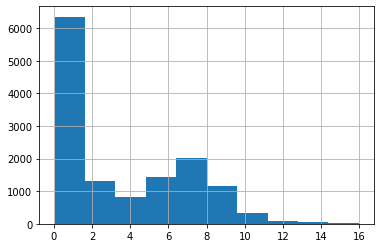

In [33]:
loss_df.loss.hist()

посчитаем значение лосса, которое будем считать выбросом. (75 квантиль + 1.5 * квантильный размах)

In [48]:
quantiles = loss_df.loss.quantile([.25, .75])
outlier_value = quantiles[.75] + 1.5 * (quantiles[.75] - quantiles[.25])
outlier_value

12.296372175216675

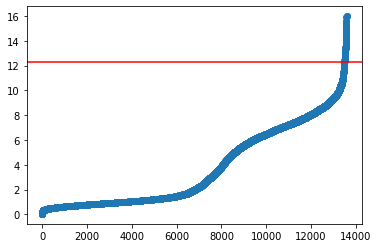

In [49]:
sort_loss = loss_df.loss.sort_values().values
indexes = range(len(sort_loss))

plt.scatter(indexes, sort_loss)
plt.axhline(y=outlier_value, color='r')

очистим датасет от данных, на которых loss слишком большой

In [37]:
filtered_data = data['train'].select(loss_df[loss_df.loss < outlier_value].index)
filtered_data

Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 13067
})

токенизируем отфильтрованные данные

In [38]:
filtered_tokenized_data = filtered_data.map(preprocess_function, batched=True)

  0%|          | 0/14 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


загрузим исходную модель заново и обучим её

In [39]:
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base')

In [ ]:
model.cuda()

In [42]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [ ]:
from transformers import Seq2SeqTrainer

filtered_trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=filtered_tokenized_data,
    eval_dataset=tokenized_data["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [44]:
filtered_trainer.train()

The following columns in the training set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: id, document, summary, labels_mask. If id, document, summary, labels_mask are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 13067
  Num Epochs = 5
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 6535


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,1.819016,0.699100,0.307400,0.286300,0.668600
2,2.254900,1.810125,0.698800,0.314600,0.289700,0.671000


Saving model checkpoint to bart-base-facebook/checkpoint-500
Configuration saved in bart-base-facebook/checkpoint-500/config.json
Model weights saved in bart-base-facebook/checkpoint-500/pytorch_model.bin
tokenizer config file saved in bart-base-facebook/checkpoint-500/tokenizer_config.json
Special tokens file saved in bart-base-facebook/checkpoint-500/special_tokens_map.json
tokenizer config file saved in bart-base-facebook/tokenizer_config.json
Special tokens file saved in bart-base-facebook/special_tokens_map.json
Saving model checkpoint to bart-base-facebook/checkpoint-1000
Configuration saved in bart-base-facebook/checkpoint-1000/config.json
Model weights saved in bart-base-facebook/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in bart-base-facebook/checkpoint-1000/tokenizer_config.json
Special tokens file saved in bart-base-facebook/checkpoint-1000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 798
  Batch size = 10


{'rouge1_fmeasure': tensor(0.6991), 'rouge1_precision': tensor(0.8503), 'rouge1_recall': tensor(0.5936), 'rouge2_fmeasure': tensor(0.3074), 'rouge2_precision': tensor(0.3739), 'rouge2_recall': tensor(0.2610), 'rougeL_fmeasure': tensor(0.2863), 'rougeL_precision': tensor(0.3482), 'rougeL_recall': tensor(0.2431), 'rougeLsum_fmeasure': tensor(0.6686), 'rougeLsum_precision': tensor(0.8131), 'rougeLsum_recall': tensor(0.5676)}


Saving model checkpoint to bart-base-facebook/checkpoint-1500
Configuration saved in bart-base-facebook/checkpoint-1500/config.json
Model weights saved in bart-base-facebook/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in bart-base-facebook/checkpoint-1500/tokenizer_config.json
Special tokens file saved in bart-base-facebook/checkpoint-1500/special_tokens_map.json
Saving model checkpoint to bart-base-facebook/checkpoint-2000
Configuration saved in bart-base-facebook/checkpoint-2000/config.json
Model weights saved in bart-base-facebook/checkpoint-2000/pytorch_model.bin
tokenizer config file saved in bart-base-facebook/checkpoint-2000/tokenizer_config.json
Special tokens file saved in bart-base-facebook/checkpoint-2000/special_tokens_map.json
Deleting older checkpoint [bart-base-facebook/checkpoint-500] due to args.save_total_limit
Saving model checkpoint to bart-base-facebook/checkpoint-2500
Configuration saved in bart-base-facebook/checkpoint-2500/config.json
Model wei

{'rouge1_fmeasure': tensor(0.6988), 'rouge1_precision': tensor(0.8532), 'rouge1_recall': tensor(0.5918), 'rouge2_fmeasure': tensor(0.3146), 'rouge2_precision': tensor(0.3840), 'rouge2_recall': tensor(0.2664), 'rougeL_fmeasure': tensor(0.2897), 'rougeL_precision': tensor(0.3537), 'rougeL_recall': tensor(0.2453), 'rougeLsum_fmeasure': tensor(0.6710), 'rougeLsum_precision': tensor(0.8192), 'rougeLsum_recall': tensor(0.5682)}


Saving model checkpoint to bart-base-facebook/checkpoint-3000
Configuration saved in bart-base-facebook/checkpoint-3000/config.json
Model weights saved in bart-base-facebook/checkpoint-3000/pytorch_model.bin
tokenizer config file saved in bart-base-facebook/checkpoint-3000/tokenizer_config.json
Special tokens file saved in bart-base-facebook/checkpoint-3000/special_tokens_map.json
Deleting older checkpoint [bart-base-facebook/checkpoint-1500] due to args.save_total_limit
Saving model checkpoint to bart-base-facebook/checkpoint-3500
Configuration saved in bart-base-facebook/checkpoint-3500/config.json
Model weights saved in bart-base-facebook/checkpoint-3500/pytorch_model.bin
tokenizer config file saved in bart-base-facebook/checkpoint-3500/tokenizer_config.json
Special tokens file saved in bart-base-facebook/checkpoint-3500/special_tokens_map.json
Deleting older checkpoint [bart-base-facebook/checkpoint-2000] due to args.save_total_limit


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,1.819016,0.699100,0.307400,0.286300,0.668600
2,2.254900,1.810125,0.698800,0.314600,0.289700,0.671000
3,1.757700,1.828979,0.722000,0.326800,0.293900,0.685200
4,1.483300,1.863273,0.716000,0.328100,0.294800,0.681900
5,1.303400,1.896478,0.729800,0.336600,0.306000,0.683100


***** Running Evaluation *****
  Num examples = 798
  Batch size = 10


{'rouge1_fmeasure': tensor(0.7220), 'rouge1_precision': tensor(0.8747), 'rouge1_recall': tensor(0.6146), 'rouge2_fmeasure': tensor(0.3268), 'rouge2_precision': tensor(0.3959), 'rouge2_recall': tensor(0.2782), 'rougeL_fmeasure': tensor(0.2939), 'rougeL_precision': tensor(0.3560), 'rougeL_recall': tensor(0.2502), 'rougeLsum_fmeasure': tensor(0.6852), 'rougeLsum_precision': tensor(0.8302), 'rougeLsum_recall': tensor(0.5834)}


Saving model checkpoint to bart-base-facebook/checkpoint-4000
Configuration saved in bart-base-facebook/checkpoint-4000/config.json
Model weights saved in bart-base-facebook/checkpoint-4000/pytorch_model.bin
tokenizer config file saved in bart-base-facebook/checkpoint-4000/tokenizer_config.json
Special tokens file saved in bart-base-facebook/checkpoint-4000/special_tokens_map.json
Deleting older checkpoint [bart-base-facebook/checkpoint-2500] due to args.save_total_limit
Saving model checkpoint to bart-base-facebook/checkpoint-4500
Configuration saved in bart-base-facebook/checkpoint-4500/config.json
Model weights saved in bart-base-facebook/checkpoint-4500/pytorch_model.bin
tokenizer config file saved in bart-base-facebook/checkpoint-4500/tokenizer_config.json
Special tokens file saved in bart-base-facebook/checkpoint-4500/special_tokens_map.json
Deleting older checkpoint [bart-base-facebook/checkpoint-3000] due to args.save_total_limit
Saving model checkpoint to bart-base-facebook/ch

{'rouge1_fmeasure': tensor(0.7160), 'rouge1_precision': tensor(0.8723), 'rouge1_recall': tensor(0.6072), 'rouge2_fmeasure': tensor(0.3281), 'rouge2_precision': tensor(0.3997), 'rouge2_recall': tensor(0.2783), 'rougeL_fmeasure': tensor(0.2948), 'rougeL_precision': tensor(0.3591), 'rougeL_recall': tensor(0.2500), 'rougeLsum_fmeasure': tensor(0.6819), 'rougeLsum_precision': tensor(0.8307), 'rougeLsum_recall': tensor(0.5783)}


Saving model checkpoint to bart-base-facebook/checkpoint-5500
Configuration saved in bart-base-facebook/checkpoint-5500/config.json
Model weights saved in bart-base-facebook/checkpoint-5500/pytorch_model.bin
tokenizer config file saved in bart-base-facebook/checkpoint-5500/tokenizer_config.json
Special tokens file saved in bart-base-facebook/checkpoint-5500/special_tokens_map.json
Deleting older checkpoint [bart-base-facebook/checkpoint-4000] due to args.save_total_limit
Saving model checkpoint to bart-base-facebook/checkpoint-6000
Configuration saved in bart-base-facebook/checkpoint-6000/config.json
Model weights saved in bart-base-facebook/checkpoint-6000/pytorch_model.bin
tokenizer config file saved in bart-base-facebook/checkpoint-6000/tokenizer_config.json
Special tokens file saved in bart-base-facebook/checkpoint-6000/special_tokens_map.json
Deleting older checkpoint [bart-base-facebook/checkpoint-4500] due to args.save_total_limit
Saving model checkpoint to bart-base-facebook/ch

{'rouge1_fmeasure': tensor(0.7298), 'rouge1_precision': tensor(0.8744), 'rouge1_recall': tensor(0.6262), 'rouge2_fmeasure': tensor(0.3366), 'rouge2_precision': tensor(0.3968), 'rouge2_recall': tensor(0.2923), 'rougeL_fmeasure': tensor(0.3060), 'rougeL_precision': tensor(0.3595), 'rougeL_recall': tensor(0.2664), 'rougeLsum_fmeasure': tensor(0.6831), 'rougeLsum_precision': tensor(0.8298), 'rougeLsum_recall': tensor(0.5804)}




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=6535, training_loss=1.6109647720208493, metrics={'train_runtime': 6494.6915, 'train_samples_per_second': 10.06, 'train_steps_per_second': 1.006, 'total_flos': 1.99185657495552e+16, 'train_loss': 1.6109647720208493, 'epoch': 5.0})

In [45]:
filtered_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 798
  Batch size = 10


{'rouge1_fmeasure': tensor(0.7298), 'rouge1_precision': tensor(0.8744), 'rouge1_recall': tensor(0.6262), 'rouge2_fmeasure': tensor(0.3366), 'rouge2_precision': tensor(0.3968), 'rouge2_recall': tensor(0.2923), 'rougeL_fmeasure': tensor(0.3060), 'rougeL_precision': tensor(0.3595), 'rougeL_recall': tensor(0.2664), 'rougeLsum_fmeasure': tensor(0.6831), 'rougeLsum_precision': tensor(0.8298), 'rougeLsum_recall': tensor(0.5804)}


{'eval_loss': 1.8964779376983643,
 'eval_rouge1': 0.7298,
 'eval_rouge2': 0.3366,
 'eval_rougeL': 0.306,
 'eval_rougeLsum': 0.6831,
 'eval_runtime': 393.5892,
 'eval_samples_per_second': 2.027,
 'eval_steps_per_second': 0.203,
 'epoch': 5.0}

<b>как видим, после удаления из обучающей выборки объектов с наибольшими значениями loss-функции, показатели всех основных метрик модели улучшились.</b>